In [56]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses04M_script03_1_F001,3,nobody knows we re here except freda and she w...
1,Ses03F_impro04_F011,4,really ?
2,Ses01M_script03_1_M003,3,we re okay right darling ? whatever happens we...
3,Ses04F_impro01_M001,2,you need a new license is that what you re tel...
4,Ses04F_script02_1_M028,4,for real ?


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

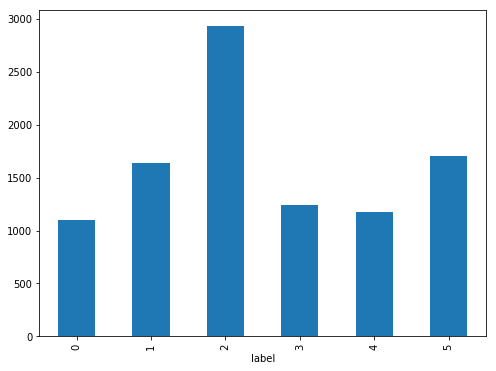

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())

Test Set Accuracy =  0.622
Test Set F-score =  0.608
Test Set Precision =  0.650
Test Set Recall =  0.620
Confusion matrix, without normalization
[[ 82  10  89  23   4  16]
 [  4 157  78  20  11  25]
 [ 22  33 423  65  17  42]
 [  0   0   0 247   0   0]
 [  0   0   0  51 200   0]
 [ 10  35 141  35  10 110]]


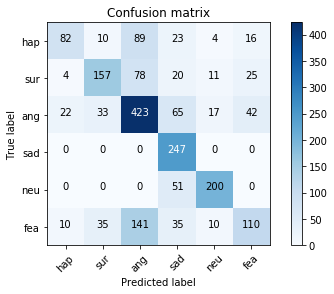

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.569
Test Set F-score =  0.550
Test Set Precision =  0.703
Test Set Recall =  0.518
Confusion matrix, without normalization
[[ 51  10 146   2   5  10]
 [  2 108 151   5   3  26]
 [  9  30 532   3   6  22]
 [  0   0  47 200   0   0]
 [  2   2  95   0 152   0]
 [  3  23 235   5   2  73]]


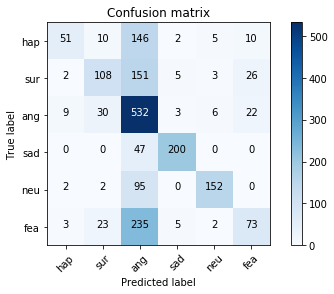

In [13]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.621
Test Set F-score =  0.617
Test Set Precision =  0.625
Test Set Recall =  0.635
Confusion matrix, without normalization
[[ 98   7  70  21   7  21]
 [  6 179  39  21  11  39]
 [ 40  42 374  51  18  77]
 [  0   0   0 247   0   0]
 [  2   2   0  51 196   0]
 [ 12  47 116  31  12 123]]


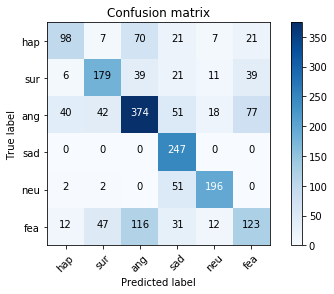

In [17]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.619
Test Set F-score =  0.621
Test Set Precision =  0.718
Test Set Recall =  0.586
Confusion matrix, without normalization
[[ 84   7 112   2   6  13]
 [  1 166  87   8   5  28]
 [ 18  25 505   4   8  42]
 [  0   0  53 194   0   0]
 [  0   6  77   0 168   0]
 [  6  27 202   8   1  97]]


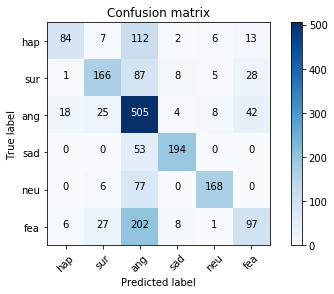

In [58]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.606
Test Set F-score =  0.615
Test Set Precision =  0.624
Test Set Recall =  0.630
Confusion matrix, without normalization
[[105  11  60  21   4  23]
 [  7 173  35  20   5  55]
 [ 55  46 330  52   6 113]
 [  0   0   0 247   0   0]
 [  0   0   0  51 190  10]
 [ 14  47 104  30   3 143]]


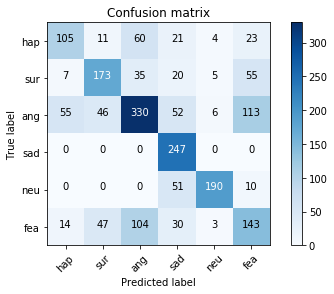

In [19]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.642
Test Set F-score =  0.643
Test Set Precision =  0.695
Test Set Recall =  0.623
Confusion matrix, without normalization
[[ 89   7  97   3   7  21]
 [  1 178  60   7  11  38]
 [ 23  31 473   7  16  52]
 [  0   0  43 204   0   0]
 [  0   4  49   2 196   0]
 [  8  42 155   8  10 118]]


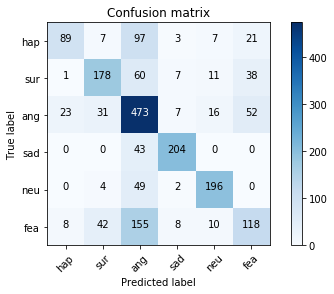

In [20]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=50, height=0.5, show_values=False)

In [33]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00107014, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Test Set Accuracy =  0.210
Test Set F-score =  0.157
Test Set Precision =  0.157
Test Set Recall =  0.165
Confusion matrix, without normalization
[[ 35  32  79  28  31  19]
 [ 31  43 115  31  40  35]
 [ 76  81 269  59  74  43]
 [ 32  22 114  25  34  20]
 [ 23  31 124  22  26  25]
 [ 40  39 161  36  52  13]]


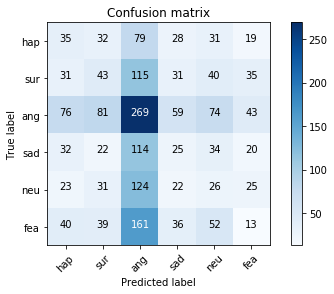

In [60]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.649
Test Set F-score =  0.660
Test Set Precision =  0.714
Test Set Recall =  0.632
Confusion matrix, without normalization
[[ 94  11  96   2   4  17]
 [  2 177  58   7   6  45]
 [ 25  30 464   5   5  73]
 [  0   0  43 204   0   0]
 [  0   2  49   2 188  10]
 [  8  35 144   7   2 145]]


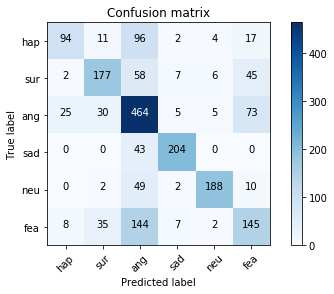

In [59]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

In [53]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:
Test Set Accuracy =  0.569
Test Set F-score =  0.550
Test Set Precision =  0.703
Test Set Recall =  0.518
Stats for top 1000 features:
Test Set Accuracy =  0.569
Test Set F-score =  0.550
Test Set Precision =  0.703
Test Set Recall =  0.518
Stats for top 1500 features:
Test Set Accuracy =  0.569
Test Set F-score =  0.550
Test Set Precision =  0.703
Test Set Recall =  0.518
Stats for top 2000 features:
Test Set Accuracy =  0.569
Test Set F-score =  0.550
Test Set Precision =  0.703
Test Set Recall =  0.518
